In [ ]:
import os
import uuid
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, activations, out_dim):
        super().__init__()
        layers, dims = [], [in_dim] + hidden_dims
        for i, h in enumerate(hidden_dims):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act = activations[i].lower()
            if   act=='relu':     layers.append(nn.ReLU())
            elif act=='tanh':     layers.append(nn.Tanh())
            elif act=='sigmoid':  layers.append(nn.Sigmoid())
            elif act=='softplus': layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown activation '{activations[i]}'")
        layers.append(nn.Linear(dims[-1], out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def cross_validate_mlp(
    csv_path: str,
    k_folds: int,
    layer_dims: list[int],
    activations: list[str],
    epochs: int,
    lr: float,
    weight_decay: float,
    batch_size: int,
    random_state: int,
    loss_type: str = 'mse',
    save_results: bool = False
):
    """
    1) Loads data from `csv_path`, with first two columns as 2D targets and the rest as inputs
       (last column categorical).
    2) Runs K-fold CV of an MLP regressor, printing per-fold MSE & R².
    3) Plots diagnostics (3 rows × 2 cols per fold):
        • Row 1: MSE Loss vs Epoch & 4-curve R² vs Epoch
        • Row 2: True vs Predicted scatter for output 1 (train & val)
        • Row 3: True vs Predicted scatter for output 2 (train & val)
    4) Optionally saves models, hyperparams, and norms into a timestamped folder.
    Returns: fold_results, histories, models, norms, feature_names
    """
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load & split
    df = pd.read_csv(csv_path)
    output_cols = df.columns[:2].tolist()
    inputs      = df.columns[2:].tolist()
    num_cols, cat_col = inputs[:-1], inputs[-1]

    # Normalize targets
    y = df[output_cols].to_numpy(dtype=np.float32)
    y_mean = y.mean(axis=0, keepdims=True)
    y_std  = y.std(axis=0, keepdims=True)
    y_std[y_std==0] = 1.0
    y_norm = (y - y_mean) / y_std

    # Normalize numeric inputs
    X_num = df[num_cols].astype(float).copy()
    x_mean = X_num.mean()
    x_std  = X_num.std().replace(0,1.0)
    X_num = (X_num - x_mean) / x_std

    # One-hot encode categorical
    X_cat = pd.get_dummies(df[cat_col].astype(str), prefix=cat_col)
    X = pd.concat([X_num, X_cat], axis=1)
    feature_names = X.columns.tolist()
    X_np = X.to_numpy(dtype=np.float32)

    # Loss function
    if loss_type=='mse':
        loss_fn = nn.MSELoss()
    elif loss_type=='huber':
        loss_fn = nn.SmoothL1Loss()
    else:
        raise ValueError("loss_type must be 'mse' or 'huber'")

    # K-Fold CV
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    fold_results, histories, models = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_np), start=1):
        X_tr, X_va = X_np[tr_idx], X_np[va_idx]
        y_tr, y_va = y_norm[tr_idx], y_norm[va_idx]

        ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
        ld_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=batch_size)

        model = MLP(
            in_dim      = X_tr.shape[1],
            hidden_dims = layer_dims,
            activations = activations,
            out_dim     = y_tr.shape[1]
        ).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        tr_losses, va_losses = [], []
        tr_r2s, va_r2s       = [], []

        for epoch in range(1, epochs+1):
            # train
            model.train()
            for xb, yb in ld_tr:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                loss_fn(model(xb), yb).backward()
                opt.step()
            # eval
            model.eval()
            with torch.no_grad():
                p_tr = model(torch.from_numpy(X_tr).to(device)).cpu().numpy()
                p_va = model(torch.from_numpy(X_va).to(device)).cpu().numpy()

            tr_losses.append(mean_squared_error(y_tr, p_tr))
            va_losses.append(mean_squared_error(y_va, p_va))
            # per-output R²
            tr_r2s.append(r2_score(y_tr, p_tr, multioutput='raw_values'))
            va_r2s.append(r2_score(y_va, p_va, multioutput='raw_values'))

        print(
            f"Fold {fold}: "
            f"train MSE={tr_losses[-1]:.4f}, train R²={np.mean(tr_r2s[-1]):.4f}, "
            f"val   MSE={va_losses[-1]:.4f}, val   R²={np.mean(va_r2s[-1]):.4f}"
        )

        fold_results.append({
            'fold': fold,
            'train_true': y_tr,
            'train_pred': p_tr,
            'val_true':   y_va,
            'val_pred':   p_va,
        })
        histories.append((tr_losses, va_losses, tr_r2s, va_r2s))
        models.append(model)

    norms = {
        'y_mean': y_mean.flatten().tolist(),
        'y_std':  y_std.flatten().tolist(),
        'x_mean': x_mean.to_dict(),
        'x_std':  x_std.to_dict(),
    }

    # Plot diagnostics
    fig, axes = plt.subplots(3 * k_folds, 2, figsize=(12, 4 * 3 * k_folds))
    for i, ((tr_losses, va_losses, tr_r2s, va_r2s), fr) in enumerate(zip(histories, fold_results)):
        base = 3 * i
        # rescale
        yt_tr = fr['train_true'] * norms['y_std'] + norms['y_mean']
        yp_tr = fr['train_pred'] * norms['y_std'] + norms['y_mean']
        yt_va = fr['val_true']   * norms['y_std'] + norms['y_mean']
        yp_va = fr['val_pred']   * norms['y_std'] + norms['y_mean']

        # Row 1: Loss & 4-curve R²
        ax_l, ax_r = axes[base, 0], axes[base, 1]
        ax_l.plot(range(1, epochs+1), tr_losses, label='train (MSE)')
        ax_l.plot(range(1, epochs+1), va_losses, label='val   (MSE)')
        ax_l.set_title(f'Fold {fr["fold"]} MSE Loss vs Epoch')
        ax_l.set_ylabel('MSE Loss'); ax_l.legend()

        tr_r2_arr = np.stack(tr_r2s)  # (epochs, 2)
        va_r2_arr = np.stack(va_r2s)
        ax_r.plot(range(1, epochs+1), tr_r2_arr[:,0], '--', label='train out1')
        ax_r.plot(range(1, epochs+1), tr_r2_arr[:,1], '--', label='train out2')
        ax_r.plot(range(1, epochs+1), va_r2_arr[:,0], '-', label='val   out1')
        ax_r.plot(range(1, epochs+1), va_r2_arr[:,1], '-', label='val   out2')
        ax_r.set_title(f'Fold {fr["fold"]} R² vs Epoch')
        ax_r.set_ylim(0,1); ax_r.legend()

        # Row 2: Output 1 scatter
        ax_t0, ax_v0 = axes[base+1, 0], axes[base+1, 1]
        yt0, yp0 = yt_tr[:,0], yp_tr[:,0]
        lim0 = [min(yt0.min(), yp0.min()), max(yt0.max(), yp0.max())]
        ax_t0.scatter(yt0, yp0, s=10, alpha=0.6); ax_t0.plot(lim0, lim0, 'k--')
        ax_t0.set_title(f'Fold {fr["fold"]} Output 1 Train')
        yt0v, yp0v = yt_va[:,0], yp_va[:,0]
        ax_v0.scatter(yt0v, yp0v, s=10, alpha=0.6); ax_v0.plot(lim0, lim0, 'k--')
        ax_v0.set_title(f'Fold {fr["fold"]} Output 1 Val')

        # Row 3: Output 2 scatter
        ax_t1, ax_v1 = axes[base+2, 0], axes[base+2, 1]
        yt1, yp1 = yt_tr[:,1], yp_tr[:,1]
        lim1 = [min(yt1.min(), yp1.min()), max(yt1.max(), yp1.max())]
        ax_t1.scatter(yt1, yp1, s=10, alpha=0.6); ax_t1.plot(lim1, lim1, 'k--')
        ax_t1.set_title(f'Fold {fr["fold"]} Output 2 Train')
        yt1v, yp1v = yt_va[:,1], yp_va[:,1]
        ax_v1.scatter(yt1v, yp1v, s=10, alpha=0.6); ax_v1.plot(lim1, lim1, 'k--')
        ax_v1.set_title(f'Fold {fr["fold"]} Output 2 Val')

    plt.tight_layout()
    plt.show()

    # Save if requested
    if save_results:
        tag = uuid.uuid4().hex[:8]
        os.makedirs(tag, exist_ok=True)
        for i, model in enumerate(models, start=1):
            torch.save(model.state_dict(), os.path.join(tag, f"{tag}_fold{i}.pth"))
        hyper = {
            "csv_path":      csv_path,
            "k_folds":       k_folds,
            "layer_dims":    layer_dims,
            "activations":   activations,
            "epochs":        epochs,
            "lr":            lr,
            "weight_decay":  weight_decay,
            "batch_size":    batch_size,
            "random_state":  random_state,
            "loss_type":     loss_type
        }
        with open(os.path.join(tag, f"{tag}_hyperparams.json"), "w") as f:
            json.dump(hyper, f, indent=4)
        print(f"Saved results under ./{tag}/")

    return fold_results, histories, models, norms, feature_names

Fold 1: train MSE=0.1349, train R²=0.8613, val   MSE=0.3316, val   R²=0.7146
Fold 2: train MSE=0.1541, train R²=0.8509, val   MSE=0.3909, val   R²=0.5134
Fold 3: train MSE=0.1445, train R²=0.8602, val   MSE=0.3136, val   R²=0.6046
Fold 4: train MSE=0.1437, train R²=0.8487, val   MSE=0.3959, val   R²=0.6876
Fold 5: train MSE=0.1471, train R²=0.8580, val   MSE=0.3543, val   R²=0.5515
Fold 6: train MSE=0.1567, train R²=0.8426, val   MSE=0.2783, val   R²=0.7268
Fold 7: train MSE=0.1328, train R²=0.8642, val   MSE=0.5637, val   R²=0.4852


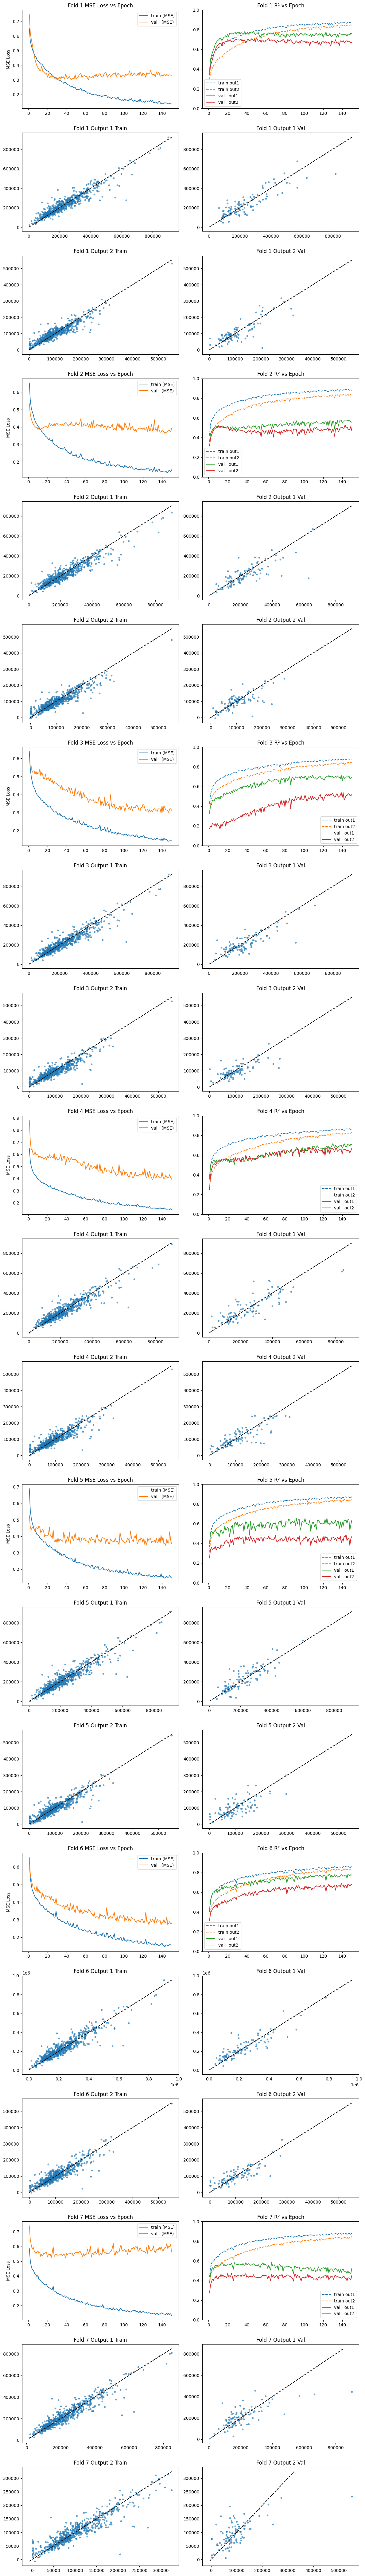

In [ ]:
res = cross_validate_mlp(
    csv_path      = '/home/kamiar/chevron/Eagle-Ford/First/data/Eagle Ford Data(Eagle Ford)_train_val.csv',
    k_folds = 7,
    layer_dims    = [128, 128],
    activations   = ['tanh', 'relu'],
    epochs        = 150,
    lr            = 5e-4,
    weight_decay  = 20e-5,
    batch_size    = 16,
    random_state = 42,
    loss_type = 'huber',
    save_results = False
)
